In [ ]:
import os
project_name = "Fashionwave_sales"
root_dir = f"ds_{project_name}"
folders = [
    root_dir,
    f"{root_dir}/csv_files",
    f"{root_dir}/outputs"
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("Folder structure created!")

Folder structure created!


###This Notebook explores the different aspects of customer behaviour in Fashion sales.The analysis uses a raw dataset.
###The objective is to clean the data, merge datasets, handle missing information, and extract meaningful insights.

In [ ]:
!pip install pandas

In [ ]:
#import the dataset
import pandas as pd
raw=pd.read_csv("/content/drive/MyDrive/projects/fashionwave_sales/FashionWave_Raw_With_Invoice.csv")
raw.head()

,InvoiceNo,Date,StoreID,StoreCity,ProductID,Category,SubCategory,UnitPrice,Cost,Quantity,Discount,CustomerType,PaymentMode,TransactionAmount,Profit,IsWeekend,Week,Year,YearWeek,DiscountBin
0,INV100000,2025-07-06,S017,Ahmedabad,P1007,Women,Tops,2510.37,1403.64,5,20.59,New,Wallet,9967.42,2949.22,True,27,2025,2025-27,20-25%
1,INV100001,2024-06-03,S034,Bengaluru,P1052,Kids,Kids-Jeans,4620.79,2970.12,2,8.51,New,Card,8455.12,2514.88,False,23,2024,2024-23,5-10%
2,INV100002,2024-11-15,S045,Lucknow,P1035,Men,T-Shirts,1020.71,617.60,2,24.04,New,Card,1550.66,315.46,False,46,2024,2024-46,20-25%
3,INV100003,2024-04-28,S001,Kolkata,P1099,Footwear,Flipflops,2510.00,1734.35,4,18.75,Student,UPI,8157.50,1220.10,True,17,2024,2024-17,15-20%
4,INV100004,2024-04-26,S046,Ahmedabad,P1022,Men,Shirts,5369.45,3854.94,2,29.38,Returning,UPI,7583.81,-126.07,False,17,2024,2024-17,25-30%


In [ ]:
raw.info()
raw.describe()
raw.isnull().sum()
print("Rows, Columns:", raw.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   InvoiceNo          50000 non-null  object 
 1   Date               50000 non-null  object 
 2   StoreID            50000 non-null  object 
 3   StoreCity          50000 non-null  object 
 4   ProductID          50000 non-null  object 
 5   Category           50000 non-null  object 
 6   SubCategory        50000 non-null  object 
 7   UnitPrice          50000 non-null  float64
 8   Cost               50000 non-null  float64
 9   Quantity           50000 non-null  int64  
 10  Discount           48427 non-null  float64
 11  CustomerType       48544 non-null  object 
 12  PaymentMode        50000 non-null  object 
 13  TransactionAmount  50000 non-null  float64
 14  Profit             50000 non-null  float64
 15  IsWeekend          50000 non-null  bool   
 16  Week               500

##**DATA** **CLEANING and Data Preprocessing**


In [ ]:
df = raw.copy()

# covert into numeric
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors='coerce')
df['Cost'] = pd.to_numeric(df['Cost'], errors='coerce')
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Discount'] = pd.to_numeric(df['Discount'], errors='coerce')

# fill missing values to 0
df['Discount'] = df['Discount'].fillna(0)

# Missing customer type -> label as Unknown (keeps rows)
df['CustomerType'] = df['CustomerType'].fillna('Unknown')

# Fill discount policy limit (>30%)
df['PolicyBreach'] = df['Discount'] > 30

# Remove or inspect rows with weird values (negative amounts, NaNs)
bad_rows = df[(df['TransactionAmount'] <= 0) | (df['Quantity'] <= 0) | df[['UnitPrice','Cost']].isnull().any(axis=1)]
print("Potential bad rows count:", bad_rows.shape[0])





Potential bad rows count: 0


In [ ]:
# Recalculate transaction-level revenue and profit from raw components
df['TransactionAmount'] = (df['UnitPrice'] * df['Quantity'] * (1 - df['Discount']/100)).round(2)
df['Profit'] = (df['TransactionAmount'] - df['Cost'] * df['Quantity']).round(2)
df.head()

,InvoiceNo,Date,StoreID,StoreCity,ProductID,Category,SubCategory,UnitPrice,Cost,Quantity,...,CustomerType,PaymentMode,TransactionAmount,Profit,IsWeekend,Week,Year,YearWeek,DiscountBin,PolicyBreach
0,INV100000,2025-07-06,S017,Ahmedabad,P1007,Women,Tops,2510.37,1403.64,5,...,New,Wallet,9967.42,2949.22,True,27,2025,2025-27,20-25%,False
1,INV100001,2024-06-03,S034,Bengaluru,P1052,Kids,Kids-Jeans,4620.79,2970.12,2,...,New,Card,8455.12,2514.88,False,23,2024,2024-23,5-10%,False
2,INV100002,2024-11-15,S045,Lucknow,P1035,Men,T-Shirts,1020.71,617.60,2,...,New,Card,1550.66,315.46,False,46,2024,2024-46,20-25%,False
3,INV100003,2024-04-28,S001,Kolkata,P1099,Footwear,Flipflops,2510.00,1734.35,4,...,Student,UPI,8157.50,1220.10,True,17,2024,2024-17,15-20%,False
4,INV100004,2024-04-26,S046,Ahmedabad,P1022,Men,Shirts,5369.45,3854.94,2,...,Returning,UPI,7583.81,-126.07,False,17,2024,2024-17,25-30%,False


##### We recalculate financials to ensure consistency — never trust a pre-computed revenue/profit column without verifying.

##### Flagging policy breaches helps later to show governance issues.

#####Detecting bad rows allows you to choose to drop them or investigate manually.

##**Feature** **Engineering**

In [ ]:
import numpy as np
# Date features
df['Date'] = pd.to_datetime(df['Date'])
df['IsWeekend'] = df['Date'].dt.weekday.isin([5,6])
df['Year'] = df['Date'].dt.year
df['WeekNum'] = df['Date'].dt.isocalendar().week
df['YearWeek'] = df['Year'].astype(str) + "-" + df['WeekNum'].astype(str).str.zfill(2)


# Profit margin per transaction
df['ProfitMargin'] = np.where(df['TransactionAmount']>0, (df['Profit'] / df['TransactionAmount']).round(4), 0)


# Discount bins for analysis
bins = [-0.1,0,5,10,15,20,25,30,100]
labels = ['0%','0-5%','5-10%','10-15%','15-20%','20-25%','25-30%','>30%']
df['DiscountBin'] = pd.cut(df['Discount'], bins=bins, labels=labels)

#####Profit margin is crucial for profitability analysis and for deciding which SKUs to promote.

#####Discount Bin makes it easy to compute average profit by discount band.

In [ ]:
df.head(5)

,InvoiceNo,Date,StoreID,StoreCity,ProductID,Category,SubCategory,UnitPrice,Cost,Quantity,...,TransactionAmount,Profit,IsWeekend,Week,Year,YearWeek,DiscountBin,PolicyBreach,WeekNum,ProfitMargin
0,INV100000,2025-07-06,S017,Ahmedabad,P1007,Women,Tops,2510.37,1403.64,5,...,9967.42,2949.22,True,27,2025,2025-27,20-25%,False,27,0.2959
1,INV100001,2024-06-03,S034,Bengaluru,P1052,Kids,Kids-Jeans,4620.79,2970.12,2,...,8455.12,2514.88,False,23,2024,2024-23,5-10%,False,23,0.2974
2,INV100002,2024-11-15,S045,Lucknow,P1035,Men,T-Shirts,1020.71,617.60,2,...,1550.66,315.46,False,46,2024,2024-46,20-25%,False,46,0.2034
3,INV100003,2024-04-28,S001,Kolkata,P1099,Footwear,Flipflops,2510.00,1734.35,4,...,8157.50,1220.10,True,17,2024,2024-17,15-20%,False,17,0.1496
4,INV100004,2024-04-26,S046,Ahmedabad,P1022,Men,Shirts,5369.45,3854.94,2,...,7583.81,-126.07,False,17,2024,2024-17,25-30%,False,17,-0.0166


##**Exploratory Data Analysis**

###**Category** **wise** **analysis**

In [ ]:
cat_summary = df.groupby('Category').agg(
    Revenue=('TransactionAmount','sum'),
    Profit=('Profit','sum'),
    UnitsSold=('Quantity','sum'),
    Transactions=('InvoiceNo','count'),
    AvgDiscount=('Discount','mean')
).reset_index().sort_values('Revenue', ascending=False)


print("=======Key metrics by category:=====")
cat_summary.head()


=======Key metrics by category:=====


,Category,Revenue,Profit,UnitsSold,Transactions,AvgDiscount
3,Men,82948324.92,14402283.57,25886,9935,14.955739
2,Kids,78797077.59,15449391.90,26154,10065,14.739780
1,Footwear,73445876.77,12652897.70,26355,10126,14.874698
0,Accessories,71122709.63,13656222.31,25458,9847,14.853528
4,Women,63734806.61,9803804.92,25784,10027,14.819929


###**WEEKEND VS WEEKDAYS ANALYSIS**

In [ ]:
week_summary = df.groupby('IsWeekend').agg(
    Revenue=('TransactionAmount','sum'),
    Profit=('Profit','sum'),
    Transactions=('InvoiceNo','count'),
    AvgAOV=('TransactionAmount','mean')
).reset_index()
print("=====Key metrics for weekend and weekday=====")

week_summary


=====Key metrics for weekend and weekday=====


,IsWeekend,Revenue,Profit,Transactions,AvgAOV
0,False,2.630993e+08,47059924.53,35609,7388.563206
1,True,1.069494e+08,18904675.87,14391,7431.689828


As in analysis it is clearly seen that Average order value for weekend is less than weekdays.So we need to strategies to rasie basket size for weekend.

###**Discount Impact by Bin**

In [ ]:
discount_impact = df.groupby('DiscountBin').agg(
    AvgProfit=('Profit','mean'),
    MedianProfit=('Profit','median'),
    Revenue=('TransactionAmount','sum'),
    Count=('InvoiceNo','count')
).reset_index()

print("======Discount Impact====")
discount_impact


======Discount Impact====


/tmp/ipython-input-5584586.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  discount_impact = df.groupby('DiscountBin').agg(


,DiscountBin,AvgProfit,MedianProfit,Revenue,Count
0,0%,2577.837400,2048.280,13604552.62,1581
1,0-5%,2381.839410,1789.150,66533008.48,7929
2,5-10%,1970.156377,1468.180,64867367.73,8055
3,10-15%,1535.565937,1032.600,60761635.69,7885
4,15-20%,1085.328731,689.430,57540807.86,8036
5,20-25%,642.967197,373.890,52267522.70,7771
6,25-30%,218.760582,115.145,49295892.49,7820
7,>30%,-436.641127,-243.520,5178007.95,923


Average profit declines sharply above 20%.so we need to recommend discount caps and targeted coupon.

###**Store performances(top and bottom)**

In [ ]:
store_perf = df.groupby('StoreID').agg(
    Revenue=('TransactionAmount','sum'),
    Profit=('Profit','sum'),
    Transactions=('InvoiceNo','count'),
    AvgAOV=('TransactionAmount','mean')
).reset_index().sort_values('Revenue', ascending=False)


top10_stores = store_perf.head(10)
bottom10_stores = store_perf.tail(10)



The idea is to analyse top 10 and botton 10 is to give promotions to the employees where the stores are in top 10.

In botton 10,we need to target local intervention like stock transfer and events.

##**Visualization**

In [ ]:
#import libraries
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols

###**Revenue by category**

<Figure size 800x500 with 0 Axes>

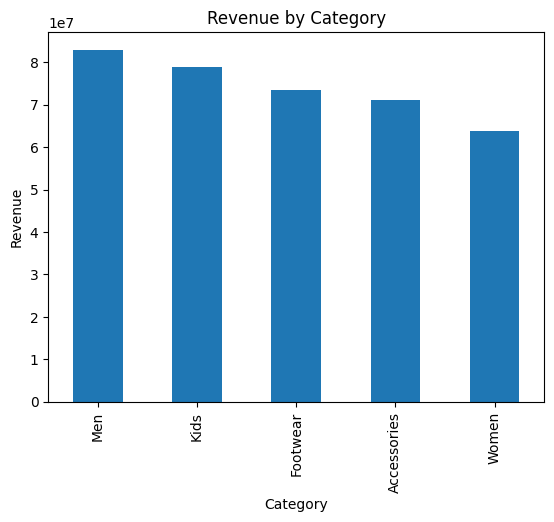

In [ ]:
plt.figure(figsize=(8,5))
cat_summary.plot(kind='bar', x='Category', y='Revenue', legend=False)
plt.title("Revenue by Category")
plt.ylabel("Revenue")
plt.show()


Total revenue is highest for Men and lowest for women.

In [ ]:
#import libraries for interactive charts
import plotly.express as px
import plotly.graph_objects as go


###**Daily Revenue Trend**

In [ ]:
daily = df.groupby('Date').agg(Revenue=('TransactionAmount', 'sum')).reset_index()

fig = px.line(
    daily,
    x="Date",
    y="Revenue",
    title="Daily Revenue Trend",
    markers=True)

fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Revenue",
    hovermode="x unified",
    template="plotly_white")

fig.show()


It can be seen from the chart that revenue jumps for a specific month.It might be the festive season.

###**Profit by Category**

In [ ]:
cat_profit = df.groupby("Category").agg(Profit=('Profit','sum')).reset_index()

fig = px.bar(
    cat_profit,
    x="Category",
    y="Profit",
    color="Category",
    title="Profit by Category",
    text_auto=".2s")

fig.update_layout(
    yaxis_title="Total Profit",
    template="plotly_white")
fig.show()


###**Weekend vs Weekday revenue**

In [ ]:
week_summary = df.groupby("IsWeekend").agg(
    Revenue=("TransactionAmount","sum")).reset_index()

week_summary["DayType"] = week_summary["IsWeekend"].map({True:"Weekend", False:"Weekday"})

fig = px.pie(week_summary,names="DayType",values="Revenue",title="Weekend vs Weekday Revenue Share",hole=0.4)

fig.update_traces(textposition="inside", textinfo="percent+label")
fig.show()


###**Revenue breakdown by Category**

In [ ]:
fig = px.sunburst(df,path=["Category", "SubCategory"],values="TransactionAmount",title="Category → SubCategory Revenue Breakdown")

fig.update_layout(template="plotly_white")
fig.show()


###**Discount vs Profit**

In [ ]:
sample = df.sample(4000)

fig = px.scatter(sample,x="Discount",y="Profit",color="Category",size="TransactionAmount",opacity=0.6,
                 title="Discount vs Profit")

fig.update_layout(template="plotly_white")
fig.show()


It is clearly seen by the chart that as the discount increase the profit sharply decreses.

###**Weekday and Weekend AOV**

In [ ]:
df["AOV"] = df["TransactionAmount"]

fig = px.box(df,x="IsWeekend",y="AOV",color="IsWeekend",title="AOV: Weekday vs Weekend",labels={"IsWeekend": "Weekend (True/False)", "AOV": "Average Order Value"},
    template="plotly_white")

fig.update_xaxes(tickvals=[0,1], ticktext=["Weekday","Weekend"])
fig.show()


###**Revenue by Discount**

In [ ]:
disc = df.groupby("DiscountBin").agg(Revenue=("TransactionAmount","sum"),Profit=("Profit","sum")).reset_index()

fig = px.bar(disc,x="DiscountBin",y="Revenue",color="Profit",title="Revenue by Discount Range",text_auto=True)

fig.update_layout(template="plotly_white")
fig.show()


/tmp/ipython-input-1254109529.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



###**Weekly Sales Trend**

In [ ]:
weekly = df.groupby("YearWeek").agg(Revenue=("TransactionAmount","sum")).reset_index()

fig = px.line(weekly,x="YearWeek",y="Revenue",title="Weekly Sales Trend",markers=True)

fig.update_layout(xaxis_title="Year-Week",yaxis_title="Revenue",template="plotly_white")

fig.show()


#**Statistical Test**

###**t-statistics**

In [ ]:
weekday_amt = df[df['IsWeekend']==False]['TransactionAmount']
weekend_amt = df[df['IsWeekend']==True]['TransactionAmount']

# Use t-test for large-sample approximate inference. If non-normal, consider Mann-Whitney.
tstat, pval = ttest_ind(weekday_amt, weekend_amt, equal_var=False)
print("t-stat:", tstat, "p-value:", pval)


t-stat: -0.7884365168495443 p-value: 0.4304484965738612


t-stat: -0.7884365168495443

This suggests weekend transaction amounts are slightly higher than weekday amounts on average.However, the value is very close to zero, indicating a very small difference

p-value: 0.4304484965738612

This is much greater than the typical significance level of 0.05 There's a 43.5% probability that any observed difference is due to random chance.



*   Any small difference observe in the data is likely just random variation.Customers don't spend significantly more or less on weekends compared to weekdays.




###**ANOVA**

In [ ]:
#Does discount bins affect profit
df_anova = df.dropna(subset=['DiscountBin'])
model = ols('Profit ~ C(DiscountBin)', data=df_anova).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                      sum_sq       df            F  PR(>F)
C(DiscountBin)  3.154890e+10      7.0  2041.762335     0.0
Residual        1.103523e+11  49992.0          NaN     NaN


as p < 0.05,Discount bins have a statistically significant effect on profit. Different discount levels lead to significantly different profit outcomes.



*   Some discount ranges are MUCH more profitable than others.

*   Discount strategy CRITICALLY impacts bottom-line profits.

*   We shouldd optimize discount offerings based on which   bins generate the highest profits.




In [ ]:
# for Power bi
weekly_kpis = df.groupby(['StoreID','StoreCity','Year','WeekNum','YearWeek']).agg(
    TotalSales=('TransactionAmount','sum'),
    WeekendSales=('TransactionAmount', lambda x: x[df.loc[x.index,'IsWeekend']].sum()),
    TotalProfit=('Profit','sum'),
    Transactions=('InvoiceNo','count'),
    UnitsSold=('Quantity','sum'),
    AvgAOV=('TransactionAmount','mean'),
    AvgDiscount=('Discount','mean')
).reset_index()

weekly_kpis['WeekendRatio'] = weekly_kpis['WeekendSales'] / weekly_kpis['TotalSales']
weekly_kpis.head()


,StoreID,StoreCity,Year,WeekNum,YearWeek,TotalSales,WeekendSales,TotalProfit,Transactions,UnitsSold,AvgAOV,AvgDiscount,WeekendRatio
0,S001,Kolkata,2023,46,2023-46,75187.08,49403.65,15235.71,8,19,9398.385000,10.962500,0.657076
1,S001,Kolkata,2023,47,2023-47,41462.16,7555.32,10481.43,5,15,8292.432000,13.066000,0.182222
2,S001,Kolkata,2023,48,2023-48,89480.15,30489.45,29071.79,9,25,9942.238889,7.513333,0.340740
3,S001,Kolkata,2023,49,2023-49,78906.92,0.00,18815.59,9,27,8767.435556,12.245556,0.000000
4,S001,Kolkata,2023,50,2023-50,19267.29,5840.56,4760.47,4,8,4816.822500,4.885000,0.303133


In [ ]:
#saving csv fiiles to dir
csv_path= f"{root_dir}/csv_files/df.csv"
df.to_csv(csv_path, index=False)

csv_path= f"{root_dir}/csv_files/raw.csv"
raw.to_csv(csv_path, index=False)

csv_path= f"{root_dir}/csv_files/cat_summary.csv"
cat_summary.to_csv(csv_path, index=False)

csv_path= f"{root_dir}/csv_files/week_summary.csv"
week_summary.to_csv(csv_path, index=False)

csv_path= f"{root_dir}/csv_files/discount_impact.csv"
discount_impact.to_csv(csv_path, index=False)

csv_path= f"{root_dir}/csv_files/top10_stores.csv"
top10_stores.to_csv(csv_path, index=False)

csv_path= f"{root_dir}/csv_files/bottom10_stores.csv"
bottom10_stores.to_csv(csv_path, index=False)

csv_path= f"{root_dir}/csv_files/weekly_kpis.csv"
weekly_kpis.to_csv(csv_path, index=False)

In [ ]:
plot_path=f"{root_dir}/outputs/weekly sales trend.png"
plt.savefig(plot_path)

plot_path=f"{root_dir}/outputs/revenue by discount.png"
plt.savefig(plot_path)

plot_path=f"{root_dir}/outputs/AOV:weekday vs weekend.png"
plt.savefig(plot_path)

plot_path=f"{root_dir}/outputs/discount vs profit.png"
plt.savefig(plot_path)

plot_path=f"{root_dir}/outputs/subcategory revenue breakdown.png"
plt.savefig(plot_path)

plot_path=f"{root_dir}/outputs/weekend bs weekday revenue share.png"
plt.savefig(plot_path)

plot_path=f"{root_dir}/outputs/Revene by category.png"
plt.savefig(plot_path)

plot_path=f"{root_dir}/outputs/profit by category.png"
plt.savefig(plot_path)

plot_path=f"{root_dir}/outputs/daily revenue trend.png"
plt.savefig(plot_path)

<Figure size 640x480 with 0 Axes>